# Convolutional Neural Networks
---
In this notebook, we train a **CNN** to classify images from the CIFAR-10 database.

The images in this database are small color images that fall into one of ten classes; some example images are pictured below.

In [1]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


## Load the Data

In [2]:
import torchvision.transforms
import multiprocessing
from helpers import get_train_val_data_loaders, get_test_data_loader

# number of subprocesses to use for data loading
num_workers = multiprocessing.cpu_count()
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transforms = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_dl, valid_dl = get_train_val_data_loaders(batch_size, valid_size, transforms, num_workers)
test_dl = get_test_data_loader(batch_size, transforms, num_workers)

data_loaders = {
    'train': train_dl,
    'valid': valid_dl,
    'test': test_dl
}

/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.8' currently installed).
  warnings.warn(msg, UserWarning)


Files already downloaded and verified
Files already downloaded and verified


In [3]:
# specify the image classes
classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

### Visualize a Batch of Training Data

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img, sub):
    img = img / 2 + 0.5  # unnormalize
    sub.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    sub.axis("off")

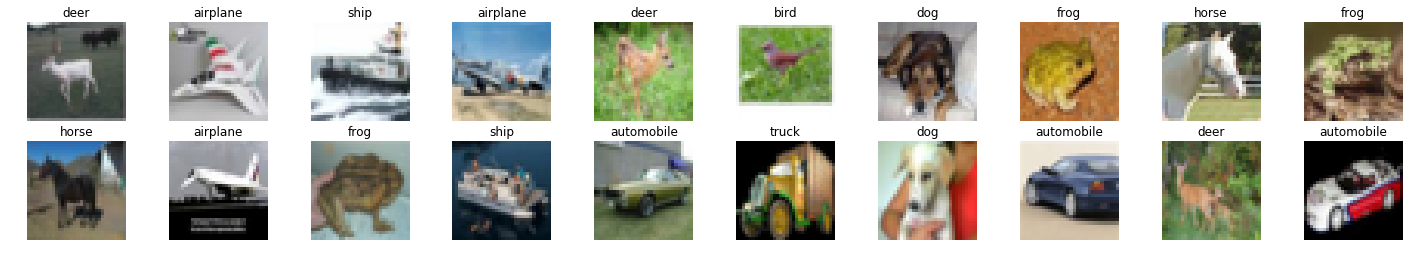

In [5]:
# obtain one batch of training images
dataiter = iter(data_loaders['train'])
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
# display 20 images
fig, subs = plt.subplots(2, 10, figsize=(25, 4))
for i, sub in enumerate(subs.flatten()):
    imshow(images[i], sub)
    sub.set_title(classes[labels[i]])

### View an Image in More Detail

Here, we look at the normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images.

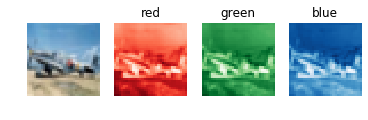

In [6]:
rgb_img = np.squeeze(images[3])
channels = ['composite', 'red', 'green', 'blue']
cmaps = [None, 'Reds', 'Greens', 'Blues']

fig, subs = plt.subplots(1, 4) 

for i, sub in enumerate(subs.flatten()):
    
    if i == 0:
        imshow(rgb_img, sub)
    else:
        img = rgb_img[i-1]
        sub.imshow(img, cmap=cmaps[i])
        sub.set_title(channels[i])
        sub.axis("off")

## Build a model with multiple convolutional layers

#### Output volume for a convolutional layer

To compute the output size of a given convolutional layer we can perform the following calculation (taken from [Stanford's cs231n course](http://cs231n.github.io/convolutional-networks/#layers)):
> We can compute the spatial size of the output volume as a function of the input volume size (W), the kernel/filter size (F), the stride with which they are applied (S), and the amount of zero padding used (P) on the border. The correct formula for calculating how many neurons define the output_W is given by `(W−F+2P)/S+1`. 

In [7]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self, n_classes=10):

        super(Net, self).__init__()

        # convolutional layer 1. It sees 3x32x32 image tensor
        # and produces 16 feature maps 32x32 (i.e., a tensor 16x32x32)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        # 2x2 pooling with stride 2. It sees tensors 16x32x32
        # and halves their size, i.e., the output will be 16x16x16
        self.pool1 = nn.MaxPool2d(2, 2)

        # convolutional layer (sees the output of the prev layer, i.e.,
        # 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)  # -> 32x16x16
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)  # -> 32x8x8

        # convolutional layer
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)  # -> 64x8x8
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2)  # -> 64x4x4

        # linear layer (64 * 4 * 4 -> 500)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        self.dp1 = nn.Dropout(0.5)
        self.rl1 = nn.ReLU()

        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, n_classes)

    def forward(self, x):

        x = self.relu1(self.pool1(self.conv1(x)))
        x = self.relu2(self.pool2(self.conv2(x)))
        x = self.relu3(self.pool3(self.conv3(x)))

        x = self.flatten(x)

        x = self.rl1(self.dp1(self.fc1(x)))

        x = self.fc2(x)

        return x


# We can also use nn.Sequential, which makes things a lot easier
class Net(nn.Module):
    def __init__(self, n_classes=10):

        super(Net, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, padding=1),  # -> 32x16x16
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # -> 32x8x8
            nn.Conv2d(32, 64, 3, padding=1),  # -> 64x8x8
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # -> 64x4x4
            nn.Flatten(),  # -> 1x64x4x4
            nn.Linear(64 * 4 * 4, 500),  # -> 500
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(500, n_classes),
        )

    def forward(self, x):

        return self.model(x)


# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=1024, out_features=500, bias=True)
    (11): Dropout(p=0.5, inplace=False)
    (12): ReLU()
    (13): Linear(in_features=500, out_features=10, bias=True)
  )
)


#### How many parameters?

In [8]:
# (16*3*3*3 + 16) + (32 * 3 * 3 * 16 + 32) + (64 * 3 * 3 * 32 + 64) + ((64 *4 *4 + 1) * 500) + (501 * 10)

sum(p.numel() for p in model.parameters() if p.requires_grad)

541094

## Visualize your network

In [9]:
scripted = torch.jit.script(model)
torch.jit.save(scripted, "cifar10_network.pt")

### Performance Tuning

Decide on a loss and optimization function that is best suited for this classification task. 

In [10]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
loss = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

## Train the Network

In [11]:
from helpers import optimize

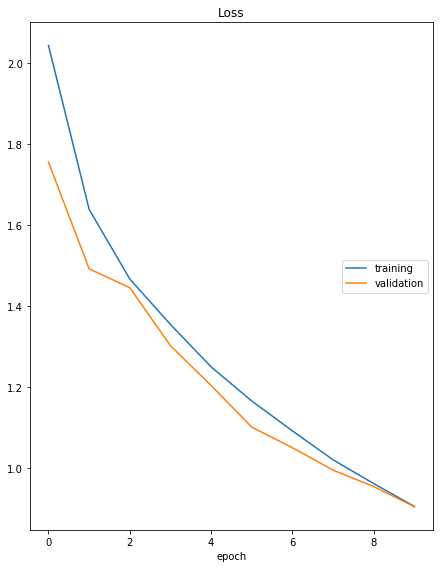

Loss
	training         	 (min:    0.905, max:    2.044, cur:    0.905)
	validation       	 (min:    0.904, max:    1.755, cur:    0.904)


In [12]:
optimize(
    data_loaders,
    model,
    optimizer,
    loss,
    10,
    "cifar10_best_valid.pt",
    interactive_tracking=True
)

###  Load the Model with the Lowest Validation Loss

In [13]:
model.load_state_dict(torch.load('cifar10_best_valid.pt'))

<All keys matched successfully>

## Test the Trained Network

In [14]:
from helpers import one_epoch_test

In [15]:
test_loss, preds, actuals = one_epoch_test(data_loaders['valid'], model, loss)

Testing: 100%|███████████████████████████████| 500/500 [00:03<00:00, 132.00it/s]

Test Loss: 0.904268


Test Accuracy: 68% (6846/10000)


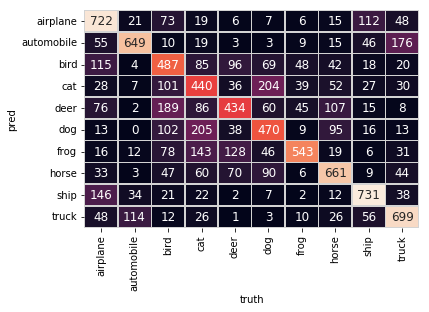

In [16]:
from helpers import plot_confusion_matrix

cm = plot_confusion_matrix(preds, actuals, classes)

In [17]:
print("Accuracy by class:\n")
for i, col in enumerate(cm):
    print(f"    {col:11s}: {cm[col][i] / cm[col].sum():.2f}")

Accuracy by class:

    airplane   : 0.58
    automobile : 0.77
    bird       : 0.43
    cat        : 0.40
    deer       : 0.53
    dog        : 0.49
    frog       : 0.76
    horse      : 0.63
    ship       : 0.71
    truck      : 0.63


### How is your model performance?

This model seems to do best on vehicles rather than animals. For example, it does best on the automobile class and worst on the cat class. I suspect it's because animals vary in color and size and so it might be improved if I could increase the number of animal images in the first place or if I added another convolutional layer to detect finer patterns in these images.

_NOTE_: we will see how to improve the performances even further with simple things like data augmentation and batch norm

### Visualize Sample Test Results

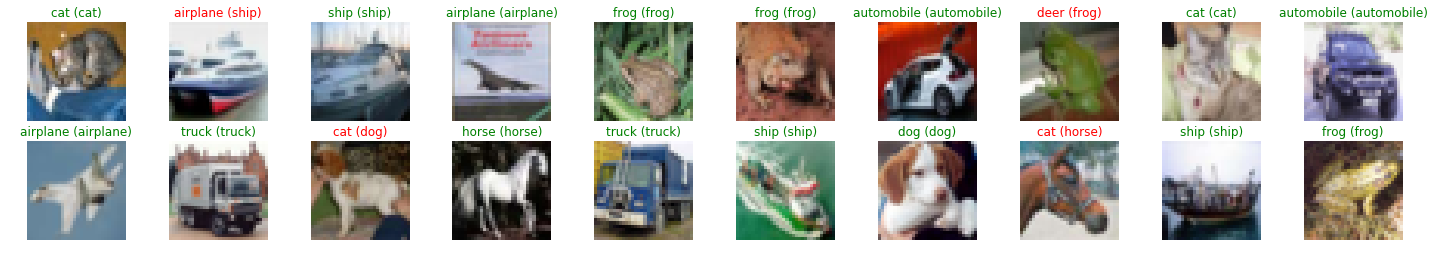

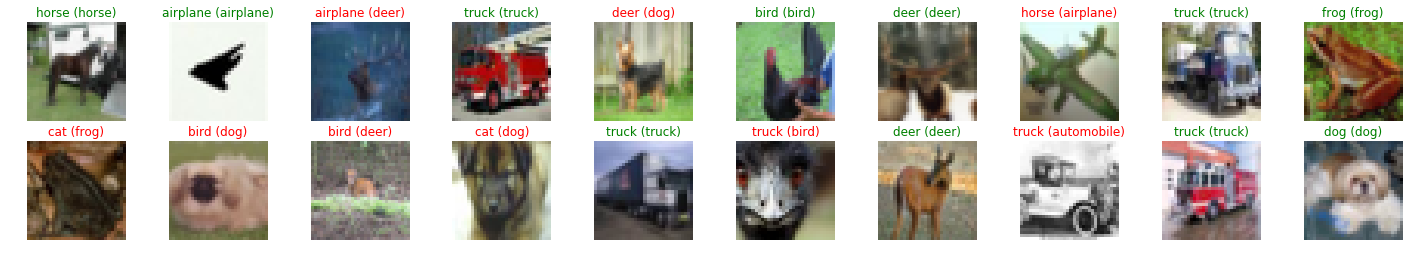

In [18]:
# obtain one batch of test images
dataiter = iter(data_loaders['test'])

for i in range(2):
    images, labels = dataiter.next()
    images.numpy()

    # move model inputs to cuda, if GPU available
    if train_on_gpu:
        images = images.cuda()

    # get sample outputs
    output = model(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

    # plot the images in the batch, along with predicted and true labels
    fig, subs = plt.subplots(2, 10, figsize=(25, 4))
    for i, ax in enumerate(subs.flatten()):
        imshow(images[i].cpu().numpy(), ax)
        ax.set_title("{} ({})".format(classes[preds[i]], classes[labels[i]]),
                     color=("green" if preds[i]==labels[i].item() else "red"))
        ax.axis("off")